# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цель работы:
С помощью модели машинного обучения определить регион, где добыча нефти принесет наибольшую прибыль

# Ход исследования:
* Загрузка и подготовка данных
* Разбить данные на обучающую и валидационную выборки в соотношении 75:25
* Обучить модель и сделать предсказания на валидационной выборке
* Напечатать на экране средний запас предсказанного сырья и RMSE модели
* Анализ результатов
* Все ключевые значения для расчётов сохранить в отдельных переменных
* Рассчитать достаточный объём сырья для безубыточной разработки новой скважины
* Сравните полученный объём сырья со средним запасом в каждом регионе
* Напишите выводы по этапу подготовки расчёта прибыли
* Выбрать скважины с максимальными значениями предсказаний.
* Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитать прибыль для полученного объёма сырья.
* Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
* Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.
* Написать выводы: предложить регион для разработки скважин и обосновать выбор.

# Описание данных

- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы)
- `product` — объём запасов в скважине (тыс. баррелей)

***Данные геологоразведки трёх регионов находятся в файлах:***  
- `/datasets/geo_data_0.csv`  
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`

# Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)   
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки  
- Бюджет на разработку скважин в регионе — 10 млрд рублей  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью 

***Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.***

## Загрузка и подготовка данных

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from scipy import stats
from phik.report import plot_correlation_matrix
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from numpy.random import RandomState
state = RandomState(12345)

**Файл, содержащий данные о первом регионе:**

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv', delimiter = ',')
pd.set_option('display.max_rows', None) #параметр для выводы всего датафрейма
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


**Файл, содержащий данные о втором регионе:**

In [4]:
geo_1 = pd.read_csv('/datasets/geo_data_1.csv', delimiter = ',')
pd.set_option('display.max_rows', None) #параметр для выводы всего датафрейма
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


**Файл, содержащий данные о третьем регионе:**

In [5]:
geo_2 = pd.read_csv('/datasets/geo_data_2.csv', delimiter = ',')
pd.set_option('display.max_rows', None) #параметр для выводы всего датафрейма
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Напишем функцию для получения детальной информации о каждом из трех датасетах:**

In [6]:
def so(geo_0):
    print(f'Размер датасета - {geo_0.shape}')
    print()
    print('Информация о данных:')
    print(geo_0.info())
    print()
    print(f'Количество пропусков в датасете: {geo_0.isna().sum().sum()}')
    print(f'Указание на пропуски в датасете: {geo_0.isna().sum()}')
    print(f'Дубликаты в датасете: {geo_0.duplicated().sum()}')

In [7]:
so(geo_0)

Размер датасета - (100000, 5)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество пропусков в датасете: 0
Указание на пропуски в датасете: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Дубликаты в датасете: 0


In [8]:
so(geo_1)

Размер датасета - (100000, 5)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество пропусков в датасете: 0
Указание на пропуски в датасете: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Дубликаты в датасете: 0


In [9]:
so(geo_2)

Размер датасета - (100000, 5)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество пропусков в датасете: 0
Указание на пропуски в датасете: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Дубликаты в датасете: 0


**Проведем визуализацию данных трех датасетов:**

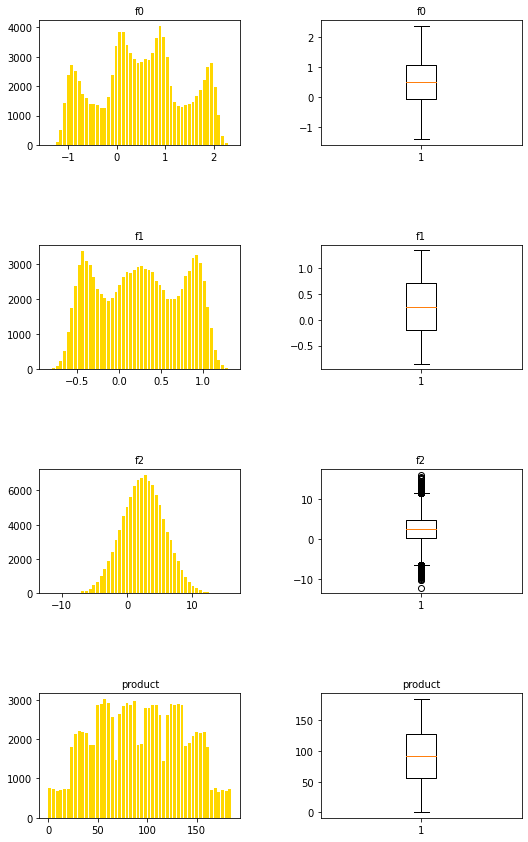

In [10]:
col = ['f0', 'f1', 'f2','product']
plt.figure(figsize = (10,30))
a = 1
for i in col:
    plt.subplot(12, 2, a)
    plt.hist(geo_0[i], bins = 50, rwidth = 0.8,color = 'gold')
    plt.title(i, size = 10)
    a = a + 1
    plt.subplot(12, 2, a)
    plt.boxplot(geo_0[i])
    plt.title(i, size = 10)
    a = a + 1

plt.subplots_adjust(left=0.13, 
                    right=0.8, 
                    top=1.4, 
                    bottom= 0.2, 
                    wspace= 0.4, 
                    hspace=0.8)
plt.show()

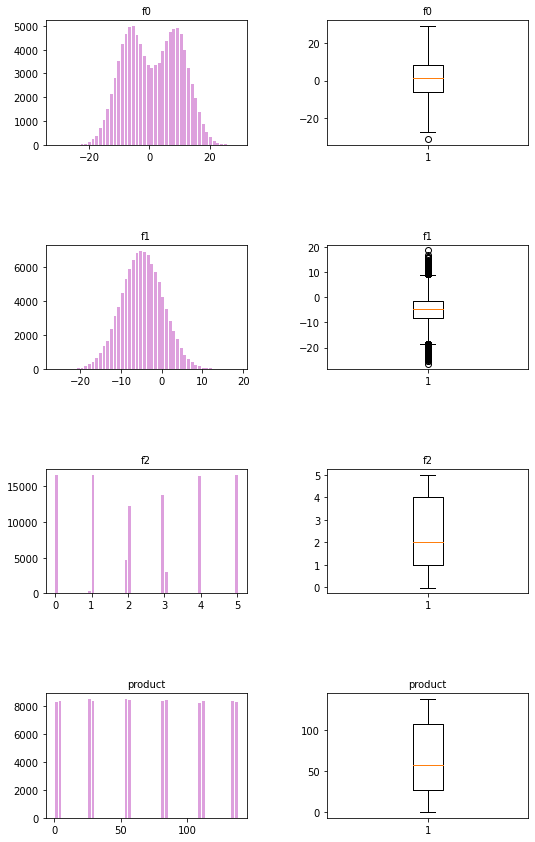

In [11]:
col = ['f0', 'f1', 'f2','product']
plt.figure(figsize = (10,30))
a = 1
for i in col:
    plt.subplot(12, 2, a)
    plt.hist(geo_1[i], bins = 50, rwidth = 0.8,color = 'plum')
    plt.title(i, size = 10)
    a = a + 1
    plt.subplot(12, 2, a)
    plt.boxplot(geo_1[i])
    plt.title(i, size = 10)
    a = a + 1

plt.subplots_adjust(left=0.13, 
                    right=0.8, 
                    top=1.4, 
                    bottom= 0.2, 
                    wspace= 0.4, 
                    hspace=0.8)
plt.show()

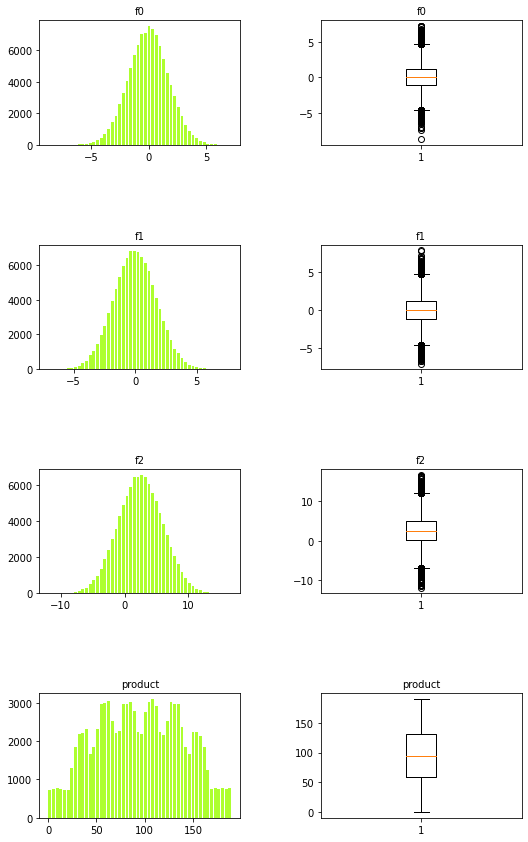

In [12]:
col = ['f0', 'f1', 'f2','product']
plt.figure(figsize = (10,30))
a = 1
for i in col:
    plt.subplot(12, 2, a)
    plt.hist(geo_2[i], bins = 50, rwidth = 0.8,color = 'greenyellow')
    plt.title(i, size = 10)
    a = a + 1
    plt.subplot(12, 2, a)
    plt.boxplot(geo_2[i])
    plt.title(i, size = 10)
    a = a + 1

plt.subplots_adjust(left=0.13, 
                    right=0.8, 
                    top=1.4, 
                    bottom= 0.2, 
                    wspace= 0.4, 
                    hspace=0.8)
plt.show()

**Наблюдаем на некоторых графиках выбросы за нижним и верхним квартилем: geo_0 - f2 , geo_1 - f0 , geo_1 - f1 , geo_2 - f0 , geo_2 - f1 , geo_2 - f2.
Посоветовавшись с преподавателем, было принято решение не удалять данные выбросы.**

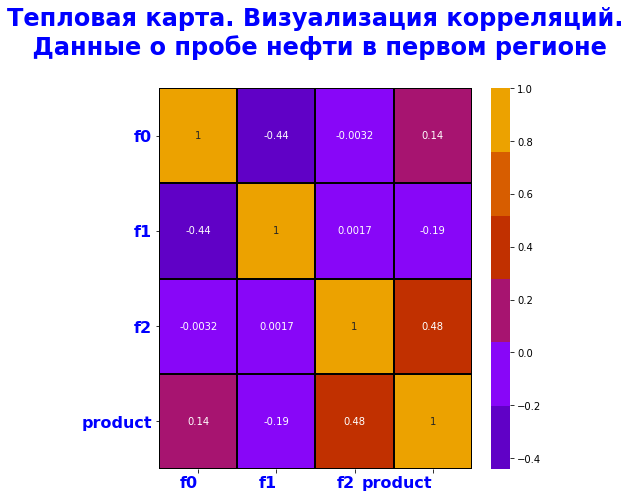

In [13]:
plt.figure(figsize=(7,7))
colormap = sns.color_palette("gnuplot")
chart = sns.heatmap(geo_0[geo_0.columns[geo_0.columns != 'id']].corr(), annot=True,
            cmap=colormap, linewidths=1, linecolor='black')
plt.title('Тепловая карта. Визуализация корреляций.\n Данные o пробе нефти в первом регионе\n', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

**Наибольшая корреляция в первом регионе наблюдается между f2 и product**

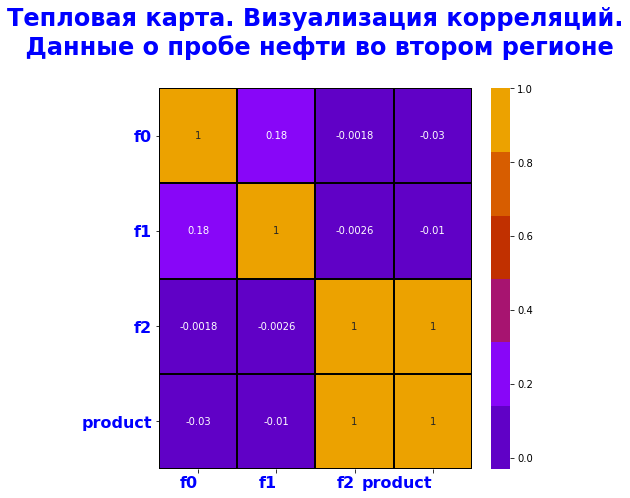

In [14]:
plt.figure(figsize=(7,7))
colormap = sns.color_palette("gnuplot")
chart = sns.heatmap(geo_1[geo_1.columns[geo_1.columns != 'id']].corr(), annot=True,
            cmap=colormap, linewidths=1, linecolor='black')
plt.title('Тепловая карта. Визуализация корреляций.\n Данные o пробе нефти во втором регионе\n', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

**Во втором регионе сильная корреляция между f2 и product**

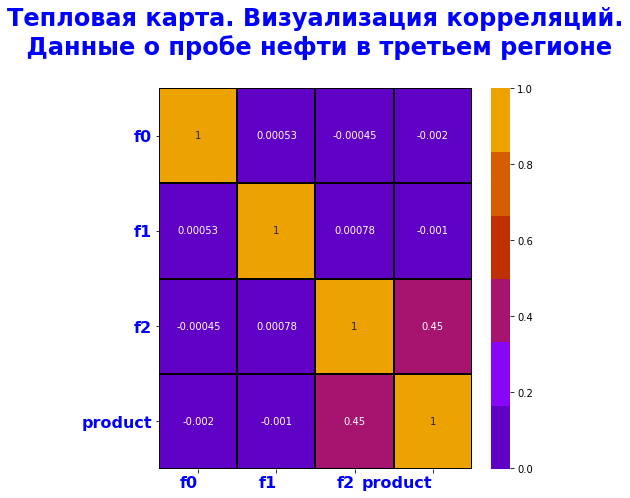

In [15]:
plt.figure(figsize=(7,7))
colormap = sns.color_palette("gnuplot")
chart = sns.heatmap(geo_2[geo_2.columns[geo_2.columns != 'id']].corr(), annot=True,
            cmap=colormap, linewidths=1, linecolor='black')
plt.title('Тепловая карта. Визуализация корреляций.\n Данные o пробе нефти в третьем регионе\n', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

**В третьем регионе ситуация, как в предыдущих двух. Высокая корреляция между f2 и product**

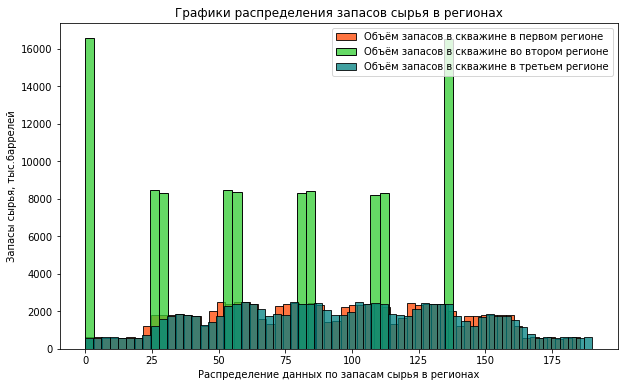

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(geo_0["product"], color="orangered", label="Объём запасов в скважине в первом регионе")
sns.histplot(geo_1["product"], color="limegreen", label="Объём запасов в скважине во втором регионе")
sns.histplot(geo_2["product"], color="teal", label="Объём запасов в скважине в третьем регионе")
plt.xlabel("Распределение данных по запасам сырья в регионах")
plt.ylabel("Запасы сырья, тыс.баррелей")
plt.title("Графики распределения запасов сырья в регионах")
plt.legend()
plt.show()

**Объём запасов в скважине во втором регионе сильно выбивается от двух других**

**Данные были загружены,последующая обработка не требуются.Была проведена визуализация, где обнаружились выбросы за нижним и верхним квартилем: geo_0 - f2 , geo_1 - f0 , geo_1 - f1 , geo_2 - f0 , geo_2 - f1 , geo_2 - f2.
Посоветовавшись с преподавателем, было принято решение не удалять данные выбросы.Объём запасов в скважине во втором регионе сильно выбивается от двух других, что видно из графика. Сильная корреляция во всех регионах между f2 и product.**

**Создадим листы для хранения результатов прогнозирования и их метрик**

In [17]:
rmse_list = []
predictions_list = []
score_list = []
target = []
data_predictions = pd.DataFrame()
data_target = pd.DataFrame()

**Проверка модели через цикл**

In [18]:
for i,j in zip([geo_0,geo_1,geo_2],range(3)):
    X = i.drop(['product','id'], axis=1)
    y = i['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=12345, test_size=0.25) 
    
    model = LinearRegression(n_jobs = -1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = np.sqrt(np.mean((y_valid-predictions)**2))
    rmse_list.append(rmse)
    predictions_list.append(predictions.mean())
    score_list.append(model.score(X_train,y_train))
    target.append(i['product'].mean())
    data_target[j] = y_valid
    data_predictions[j] = predictions

**Создание сравнительной таблицы:**

In [19]:
data_target = data_target.reset_index(drop=True)
scorelist = pd.DataFrame(data=[rmse_list, score_list, predictions_list, target], index=['RMSE','SCORE','Predicted_mean',
'Target_mean'], columns=['Регион 1','Регион 2','Регион 3'])
display(scorelist)

,Регион 1,Регион 2,Регион 3
RMSE,37.579422,0.893099,40.029709
SCORE,0.274239,0.999625,0.196614
Predicted_mean,92.592568,68.728547,94.965046
Target_mean,92.500000,68.825000,95.000000


**Лучше всего LinearRegression  работает со вторым регионом, что не удивительно, учитывая коэффициенты взаимосвязи между целевым и остальными признаками данных по нему.**


## Подготовка к расчёту прибыли

**Все ключевые значения для расчётов сохраним в отдельных переменных**

In [20]:
points_explore = 500 #при разведке региона исследуют 500 точек
best_points = 200 #с помощью машинного обучения выбирают 200 лучших для разработки
budget = 10e9 #бюджет на разработку скважин в регионе
price_one = 450e3 #доход с каждой единицы продукта составляет
probability_of_losses = 0.025 #после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
bootstrap_samples = 1000

In [21]:
print('Для безубыточной разработки {} скважин нужно получить в среднем по {:.2f} тыс. баррелей с каждой'
      .format(best_points, budget/price_one/best_points))

Для безубыточной разработки 200 скважин нужно получить в среднем по 111.11 тыс. баррелей с каждой


**Полученное значение больше, чем среднее, предсказанное по любому из регионов.**

**Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели**

In [22]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (price_one* selected.sum() - (budget))

**Посчитаем прибыль на каждый регион**

In [23]:
print('Прибыль первого региона : {:.2f}  млрд рублей'.format(revenue(data_target[0], data_predictions[0],best_points)/10**9))
print('Прибыль второго региона : {:.2f} млрд рублей'.format(revenue(data_target[1], data_predictions[1],best_points)/10**9))
print('Прибыль третьего региона :{:.2f} млрд рублей'.format(revenue(data_target[2], data_predictions[2],best_points)/10**9))

Прибыль первого региона : 3.32  млрд рублей
Прибыль второго региона : 2.42 млрд рублей
Прибыль третьего региона :2.71 млрд рублей


## Расчёт прибыли и рисков 

In [24]:
revenues = []
final_revenues = []

In [25]:
for i in range(1000):
    target_subsample = data_target[0].sample(n=500, replace=True, random_state=state)
    probs_subsample = data_predictions[0][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))

print("Среднее значение прибыли:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('Регион 1', mean/10**9, lower/10**9, confidence_interval, risks))

Среднее значение прибыли: 0.4259385269105924
2.5%-квантиль: -0.10209009483793653
Риск: 6.0 %
95% доверительный интервал:  (-102090094.83793654, 947976353.3583689)


In [26]:
revenues = []
final_revenues = []

In [27]:
for i in range(1000):
    target_subsample = data_target[1].sample(n=500, replace=True, random_state=state)
    probs_subsample = data_predictions[1][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))

print("Среднее значение прибыли:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('Регион 2', mean/10**9, lower/10**9, confidence_interval, risks))

Среднее значение прибыли: 0.5182594936973248
2.5%-квантиль: 0.12812323143308443
Риск: 0.3 %
95% доверительный интервал:  (128123231.43308444, 953612982.0669085)


In [28]:
revenues = []
final_revenues = []

In [29]:
for i in range(1000):
    target_subsample = data_target[2].sample(n=500,replace=True, random_state=state)
    probs_subsample = data_predictions[2][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))

print("Среднее значение прибыли:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('Регион 3', mean/10**9, lower/10**9, confidence_interval, risks))

Среднее значение прибыли: 0.4201940053440501
2.5%-квантиль: -0.11585260916001143
Риск: 6.2 %
95% доверительный интервал:  (-115852609.16001143, 989629939.8445739)


# Общий вывод:

**Данные были загружены,последующая обработка не требуются.Была проведена визуализация, где обнаружились выбросы за нижним и верхним квартилем: geo_0 - f2 , geo_1 - f0 , geo_1 - f1 , geo_2 - f0 , geo_2 - f1 , geo_2 - f2.
Посоветовавшись с преподавателем, было принято решение не удалять данные выбросы.Объём запасов в скважине во втором регионе сильно выбивается от двух других, что видно из графика. Сильная корреляция во всех регионах между f2 и product.**

**Исходя из всех результатов моделей мы получили такие результаты:**

* Регион 1: RMSE	37.579422; SCORЕ 0.274239	
* Регион 2: RMSE : 0.893099 ; SCORE 0.999625	
* Регион 3: RMSE : 40.029709 ; SCORE  0.196614


**Для разработки рекомендован второй регион, как единственный отвечающий критерию Риск < 2.5%, но, даже если не учитывать критерий:**
* Риск убытков минимален по сравнению с другими регионами, и в случае убытков потери относительно невелики;
* Является самым предсказуемым для моделирования;
* Показал самое высокое среднее значение прибыли.